## Import des librairies

In [15]:
import warnings
warnings.filterwarnings("ignore")

import json
import glob
import pickle
import os
import time
import optuna
import numpy                    as np
import matplotlib.pyplot        as plt
import pandas                   as pd
import tensorflow 	            as tf
import tensorflow.keras.backend as K
import tensorflow_probability   as tfp
import keras
from   keras                    import ops
from   lightgbm                 import LGBMRegressor
from   xgboost                  import XGBRegressor
from   keras                    import layers
from   IPython.display          import FileLink
from   tensorflow.keras         import layers, models, Input, Sequential, regularizers
from   tensorflow.keras.layers  import Dense, Input, Concatenate, BatchNormalization, Dropout
from   tensorflow.keras.models  import Model
from   sklearn.model_selection  import train_test_split, RandomizedSearchCV
from   sklearn.ensemble         import StackingRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, VotingRegressor
from   sklearn.linear_model     import Ridge, Lasso, ElasticNet
from   sklearn.neighbors        import KNeighborsRegressor
from   sklearn.neural_network   import MLPRegressor
from   sklearn.svm              import SVR
from   sklearn.gaussian_process import GaussianProcessRegressor
from   sklearn.metrics          import mean_absolute_error
from   sklearn.inspection       import permutation_importance
from   scipy.stats              import ttest_ind, randint, uniform, norm 

from sklearn.ensemble                 import *
from sklearn.linear_model             import *
from sklearn.neighbors                import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.svm                      import SVR, LinearSVR, NuSVR
from sklearn.neural_network           import MLPRegressor
from sklearn.gaussian_process         import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.tree                     import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.isotonic                 import IsotonicRegression
from sklearn.kernel_ridge             import KernelRidge
from sklearn.cross_decomposition      import PLSRegression
from sklearn.multioutput              import MultiOutputRegressor
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic

## Définition des constantes

In [2]:
NB_OF_KEYPOINTS = 468
NB_OF_PUPILS_COORDS = 4

orientations = ["haut-gauche",
               "haut",
               "haut-droite",
               "gauche",
               "milieu",
               "droite",
               "bas-gauche",
               "bas",
               "bas-droite",
               "position quelconque",
               "position quelconque",
               "position quelconque"]

points = [[0  , 0],
          [0.5, 0],
          [1  , 0],
          [0  , 0.5],
          [0.5, 0.5],
          [1  , 0.5],
          [0  , 1],
          [0.5, 1],
          [1  , 1],
          [-1 , -1],
          [-1 , -1],
          [-1 , -1]]

NB_OF_ORIENTATIONS = len(orientations)
NB_OF_POINTS = len(points)
latent_dim = 64

## Création du dataset

In [3]:
def create_dataset(json_file_name):
    with open(json_file_name, "r") as f:
        json_file = json.load(f)

    labels = []
    values = []
    i = 0
    for dico in json_file :
        values += [[]]
        for element in dico["landmarks"]:
            values[-1] += [element[0]] + [element[1]] + [element[2]]
        
        values[-1] += dico["pupil_left"] + dico["pupil_right"]
        values[-1] += [dico["gaze_prediction"][0] / dico["metadata"]["window_size"][0]]
        values[-1] += [dico["gaze_prediction"][1] / dico["metadata"]["window_size"][1]]
        
    for i in range(len(dico["landmarks"] * 3) // 3):
        labels += ["x_" + str(i)] + ["y_" + str(i)] + ["z_" + str(i)]

    labels += ["x_pupil_left", "y_pupil_left", "x_pupil_right", "y_pupil_right"]
    labels += ["x_point", "y_point"]
    
    global screen_resolution
    global window_size
    screen_resolution = dico["metadata"]["screen_resolution"]
    window_size = dico["metadata"]["window_size"]

    csv = pd.DataFrame(values, columns = labels)

    file_name = json_file_name.split("/")
    csv.to_csv("dataset/" + file_name[-1][:-4] + ".csv", index = False)
    FileLink("dataset/" + file_name[-1][:-4] + ".csv")

## Import du dataset

In [4]:
pd.set_option("display.max_columns", None)
json_files = glob.glob("json/*.json", recursive = True)
for f in json_files:
    create_dataset(f)

csv_files = glob.glob("dataset/*.csv", recursive = True)
df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index = True)
#df = pd.read_csv("dataset.csv")

## Découpage des données

In [5]:
def split_data(df):
    #shuffle rows
    df.sample(frac = 1)
    X = np.array(df.drop(["x_point", "y_point"], axis = 1))
    y = np.array(df[["x_point", "y_point"]])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
    return(X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = split_data(df)

## Création du nouveau dataset

In [6]:
def create_point_clouds(df):
    point_clouds = np.zeros((len(df), NB_OF_KEYPOINTS, 3))
    for i in range(len(df)):
        df_row = df.iloc[i].to_dict()
        point_clouds[i] = create_point_cloud(df_row)

    return(point_clouds)

def create_point_cloud(df_row):
    point_cloud = np.zeros((NB_OF_KEYPOINTS, 3))
    for i in range(NB_OF_KEYPOINTS):
        point_cloud[i] = np.array([df_row["x_" + str(i)], df_row["y_" + str(i)], df_row["z_" + str(i)]])

    return(point_cloud)

def get_centers_and_vectors(point_clouds, reference_vector = None):
    centers = np.zeros((len(point_clouds), 3))
    vectors = np.zeros((len(point_clouds), 3))
    for i in range(len(point_clouds)):
        centroid = np.mean(point_clouds[i], axis = 0)
        centered = point_clouds[i] - centroid
        _, _, transposed_right_singular_vectors = np.linalg.svd(centered)
        normal_vector = transposed_right_singular_vectors[-1, :]
        unit_normal_vector = normal_vector / np.linalg.norm(normal_vector)

        scalar_product = np.dot(unit_normal_vector, reference_vector)
        if reference_vector is not None and scalar_product > 0:
            unit_normal_vector = -unit_normal_vector
        
        centers[i] = centroid
        vectors[i] = unit_normal_vector

    return(centers, vectors)

def get_angles(vectors, reference_vector):
    angles =  np.zeros((len(vectors), 3))
    for i in range(len(vectors)):
        u = vectors[i]
        v = reference_vector

        # Rotation matrix
        R = np.linalg.inv(np.array([u, np.cross(u, v), np.cross(u, np.cross(u, v))]).T) @ np.array([v, np.cross(u, v), np.cross(u, np.cross(u, v))]).T
        
        beta  = np.arctan2(-R[2, 0], np.sqrt(R[0, 0] ** 2 + R[1, 0] ** 2))
        alpha = np.arctan2(R[1, 0] / np.cos(beta), R[0, 0] / np.cos(beta))
        gamma = np.arctan2(R[2, 1] / np.cos(beta), R[2, 2] / np.cos(beta))

        angles[i] = np.array([alpha, beta, gamma])

    return(angles)

def get_eyes(point_clouds):
    left_eyes_indexes  = np.array([263, 466, 388, 387, 386, 385, 384, 398, 362, 382, 381, 380, 374, 373, 390, 249])
    right_eyes_indexes = np.array([ 33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163,   7])
    
    left_eyes  = np.zeros((len(point_clouds), len(left_eyes_indexes), 3))
    right_eyes = np.zeros((len(point_clouds), len(right_eyes_indexes), 3))
    for i in range(len(point_clouds)):
        for j in range(len(right_eyes_indexes)):
            left_eyes[i][j]  = point_clouds[i][left_eyes_indexes[j]]
            right_eyes[i][j] = point_clouds[i][right_eyes_indexes[j]]

    return(left_eyes, right_eyes)

def get_xy_coord(x_pupil, y_pupil, reference_vector, eye):
    radius = 12.5
    centroid = np.mean(eye, axis = 0)
    _, _, transposed_right_singular_vectors = np.linalg.svd(eye)
    normal_vector = transposed_right_singular_vectors[-1, :]
    unit_normal_vector = normal_vector / np.linalg.norm(normal_vector)

    scalar_product = np.dot(unit_normal_vector, reference_vector)
    if reference_vector is not None and scalar_product < 0:
        unit_normal_vector = -unit_normal_vector

    center = centroid + radius * unit_normal_vector
    focal_point = centroid + 2 * radius * unit_normal_vector

    xy_coord = get_intersection(center, radius, focal_point, x_pupil, y_pupil)
    
    return(xy_coord)

def get_intersection(center, radius, focal_point, x_pupil, y_pupil):
    dz = np.sqrt(max(0, radius**2 - (x_pupil - center[0])**2 - (y_pupil - center[1])**2))
    z_pupil = center[2] - dz

    pupil = np.array([x_pupil, y_pupil, z_pupil])
    look_vector = pupil - focal_point

    screen_distance = 600
    scaler = (screen_distance - focal_point[2]) / look_vector[2]

    x_coord = focal_point[0] + scaler * look_vector[0]
    y_coord = focal_point[1] + scaler * look_vector[1]

    xy_coord = np.array([x_coord, y_coord])
    return(xy_coord)

def get_xy_coords(left_eyes, right_eyes, reference_vector, df, centers):
    left_xy_coords  = np.zeros((len(df), 2))
    right_xy_coords = np.zeros((len(df), 2))
    for i in range(len(df)):
        x_pupil_left  = df.loc[i, "x_pupil_left"] - centers[i][0]
        y_pupil_left  = df.loc[i, "y_pupil_left"] - centers[i][1]
        x_pupil_right = df.loc[i, "x_pupil_right"] - centers[i][0]
        y_pupil_right = df.loc[i, "y_pupil_right"] - centers[i][1]

        left_xy_coords[i]  = get_xy_coord(x_pupil_left, y_pupil_left, reference_vector, left_eyes[i])
        right_xy_coords[i] = get_xy_coord(x_pupil_right, y_pupil_right, reference_vector, right_eyes[i])
    
    return(left_xy_coords, right_xy_coords) 

def get_centered_pupils(df, centers):
    centered_pupils = np.zeros((len(df), 4))
    for i in range(len(df)):
        x_pupil_left  = df.loc[i, "x_pupil_left"] - centers[i][0]
        y_pupil_left  = df.loc[i, "y_pupil_left"] - centers[i][1]
        x_pupil_right = df.loc[i, "x_pupil_right"] - centers[i][0]
        y_pupil_right = df.loc[i, "y_pupil_right"] - centers[i][1]

        centered_pupils[i]  = np.array([x_pupil_left, y_pupil_left, x_pupil_right, y_pupil_right])
        
    return(centered_pupils)

def get_distances(centers, centered_eyes_centroid, centered_pupils):
    distances           = np.zeros((len(centered_pupils), 3))
    for i in range(len(centered_pupils)):
        centered_left_eyes  = centered_eyes_centroid[i][:3]
        centered_right_eyes = centered_eyes_centroid[i][3:]
    
        pupils_distance = np.linalg.norm(centered_pupils[i][:2] - centered_pupils[i][2:])
        eyes_distance   = np.linalg.norm(centered_left_eyes[:2] - centered_right_eyes[2:])

        left_distance  = np.linalg.norm(centered_pupils[i][:2] - centered_left_eyes[:2])
        right_distance = np.linalg.norm(centered_pupils[i][2:] - centered_right_eyes[:2])

        distances[i][0] = pupils_distance / eyes_distance
        distances[i][1] = left_distance / right_distance
        distances[i][2] = np.linalg.norm(centers[i])

    return(distances)
          

def get_eyes_centroid(left_eyes, right_eyes):
    left_eyes_centroid  = np.zeros((len(df), 3))
    right_eyes_centroid = np.zeros((len(df), 3))
    for i in range(len(df)):
        left_eyes_centroid[i]  = np.mean(left_eyes[i], axis = 0)
        right_eyes_centroid[i] = np.mean(right_eyes[i], axis = 0)
    
    eyes_centroid = np.column_stack((left_eyes_centroid, right_eyes_centroid))
    return(eyes_centroid)
'''
def get_sphere_centers(point_clouds, radius):
    left_eyes_indexes  = np.array([386, 374])
    right_eyes_indexes = np.array([159, 145])
    
    left_eyes  = np.zeros((len(point_clouds), len(left_eyes_indexes), 3))
    right_eyes = np.zeros((len(point_clouds), len(right_eyes_indexes), 3))

    left_centers  = np.zeros((len(point_clouds), 3))
    right_centers = np.zeros((len(point_clouds), 3)) 
    
    for i in range(len(point_clouds)):
        for j in range(len(right_eyes_indexes)):
            left_eyes[i][j]  = point_clouds[i][left_eyes_indexes[j]]
            right_eyes[i][j] = point_clouds[i][right_eyes_indexes[j]]

        left_centers[i]  = get_sphere_center(left_eyes[i], radius)
        right_centers[i] = get_sphere_center(right_eyes[i], radius)

    return(left_centers, right_centers)

def get_sphere_center(eye, radius):
    A, B = eye
    center = np.mean(eye, axis = 0)
    
    dx = center[0] - A[0]
    dy = center[1] - A[1]
    current_distance_xy = np.sqrt(dx**2 + dy**2)
    
    if current_distance_xy >= radius:
        print("error")
        raise ValueError("No solutions : xy distance is to big.")
    
    dz = np.sqrt(radius**2 - current_distance_xy**2)
    z = A[2] + dz
    
    center = np.array([center[0], center[1], z])
    return(center)


def get_xy_coords(left_centers, right_centers, radius, df):
    xy_coords_left  = np.zeros((len(df), 2))
    xy_coords_right = np.zeros((len(df), 2))
    
    for i in range(len(df)):
        x_pupil_left  = df.loc[i, "x_pupil_left"] 
        y_pupil_left  = df.loc[i, "y_pupil_left"] 
        x_pupil_right = df.loc[i, "x_pupil_right"]
        y_pupil_right = df.loc[i, "y_pupil_right"]
        
        xy_coords_left[i]  = get_xy_coord(left_centers[i], radius, x_pupil_left, y_pupil_left)
        xy_coords_right[i] = get_xy_coord(right_centers[i], radius, x_pupil_right, y_pupil_right)

    return(xy_coords_left, xy_coords_right)

def get_pupils_proportion(df, point_clouds):
    left_tips_indexes  = np.array([263, 386, 362, 374])
    right_tips_indexes = np.array([ 33, 159, 133, 145])

    left_tips  = np.zeros((len(point_clouds), len(left_tips_indexes), 3))
    right_tips = np.zeros((len(point_clouds), len(right_tips_indexes), 3))
    
    pupils_proportion = np.zeros((len(point_clouds), 4))
    for i in range(len(point_clouds)):
        for j in range(len(right_tips_indexes)):
            left_tips[i][j]  = point_clouds[i][left_tips_indexes[j]]
            right_tips[i][j] = point_clouds[i][right_tips_indexes[j]]

        x_pupil_left  = df.loc[i, "x_pupil_left"] 
        y_pupil_left  = df.loc[i, "y_pupil_left"] 
        x_pupil_right = df.loc[i, "x_pupil_right"]
        y_pupil_right = df.loc[i, "y_pupil_right"]
        
        left_x_proportion  = (x_pupil_left  - left_tips[i][0][0] ) / (left_tips[i][2][0]  - left_tips[i][0][0] )
        left_y_proportion  = (y_pupil_left  - left_tips[i][3][1] ) / (left_tips[i][1][1]  - left_tips[i][3][1] )
        right_x_proportion = (x_pupil_right - right_tips[i][2][0]) / (right_tips[i][0][0] - right_tips[i][2][0])
        right_y_proportion = (y_pupil_right - right_tips[i][3][1]) / (right_tips[i][1][1] - right_tips[i][3][1])

        pupils_proportion[i] = np.array([left_x_proportion, left_y_proportion, right_x_proportion, right_y_proportion])

    return(pupils_proportion)
'''

def get_optimal_df(centers, vectors, centered_eyes_centroid, centered_pupils, look_vectors, distances, y):
    labels = ["x_center", 
              "y_center", 
              "z_center", 
              "alpha",
              "beta",
              "gamma", 
              "x_left_eyes",
              "y_left_eyes",
              "z_left_eyes",
              "x_right_eyes",
              "y_right_eyes",
              "z_right_eyes",
              "x_left_pupils",
              "y_left_pupils",
              "x_right_pupils",
              "y_right_pupils",
              "x_left_look_vector",
              "y_left_look_vector",
              "x_right_look_vector",
              "y_right_look_vector",
              "pupils_distance",
              "left_right_ratio",
              "face_distance",
              "x_point",
              "y_point"]
    
    #values = np.column_stack((centers, vectors, eyes_centroid, centered_pupils, y))
    values = np.hstack((centers, vectors, centered_eyes_centroid, centered_pupils, look_vectors, distances, y))
    optimal_df = pd.DataFrame(values, columns = labels)
    return(optimal_df)
        
def create_optimal_df(df):
    reference_vector = np.array([0, 0, 1])
    radius = 15 # radius of a human eye
    point_clouds = create_point_clouds(df)
    centers, vectors = get_centers_and_vectors(point_clouds, reference_vector)
    centered_point_clouds = point_clouds - centers[:, np.newaxis, :]
    angles = get_angles(vectors, reference_vector)
    left_eyes, right_eyes = get_eyes(point_clouds)
    centered_left_eyes, centered_right_eyes = get_eyes(centered_point_clouds)
    #left_centers, right_centers = get_sphere_centers(point_clouds, radius)
    #left_xy_coords, right_xy_coords = get_xy_coords(left_eyes, right_eyes, reference_vector, df, centers)
    centered_eyes_centroid = get_eyes_centroid(centered_left_eyes, centered_right_eyes)
    centered_pupils = get_centered_pupils(df, centers)
    centered_eyes_centroid_without_z = np.delete(centered_eyes_centroid, [2, 5], axis=1)
    look_vectors = centered_pupils - centered_eyes_centroid_without_z
    distances = get_distances(centers, centered_eyes_centroid, centered_pupils)
    #pupils_proportion = get_pupils_proportion(df, point_clouds)
    #left_look_vectors, right_look_vectors = get_look_vectors(left_eyes, right_eyes, df, centers)
    y = np.array(df[["x_point", "y_point"]])
    #optimal_df = get_optimal_df(centers, vectors, left_look_vectors, right_look_vectors, y)
    #optimal_df = get_optimal_df(centers, vectors, eyes_centroid, centered_pupils, xy_coords_left, xy_coords_right, y)
    optimal_df = get_optimal_df(centers, vectors, centered_eyes_centroid, centered_pupils, look_vectors, distances, y)
    return(optimal_df)

optimal_df = create_optimal_df(df)
optimal_df.to_csv("optimal_df/" + "df" + ".csv", index = False)
FileLink("optimal_df/" + "df" + ".csv")
X_train, X_test, y_train, y_test = split_data(optimal_df)
print(X_train[0])

[ 3.37330904e+02  2.43412427e+02  8.51725075e-03 -8.24415249e-03
 -7.97004242e-02 -9.96784769e-01  4.48156797e+01 -3.94300972e+01
  5.39356452e+00 -3.96557711e+01 -4.17620875e+01  6.63976018e+00
  4.16690962e+01 -4.24124266e+01 -3.83309038e+01 -4.44124266e+01
 -3.14658356e+00 -2.98232937e+00  1.32486725e+00 -2.65033913e+00
  1.33750158e+00  1.46314619e+00  4.15982870e+02]


## Initialisation du réseaux de neurones

In [7]:
def init_model():
    model = tf.keras.Sequential([
            tf.keras.Input(shape = (NB_OF_KEYPOINTS * 3 + NB_OF_PUPILS_COORDS,)),
            tf.keras.layers.Dense(512, activation = "relu"),
            tf.keras.layers.Dense(128, activation = "relu"),
            tf.keras.layers.Dense(32, activation = "relu"),
            tf.keras.layers.Dense(8, activation = "relu"),
            tf.keras.layers.Dense(2)
    ])
    return(model)
    
def init_model_encoded():
    model_encoded = tf.keras.Sequential([
                    tf.keras.Input(shape = (latent_dim,)),
                    tf.keras.layers.Dense(latent_dim, activation = "relu"),
                    tf.keras.layers.Dense(latent_dim, activation = "relu"),
                    tf.keras.layers.Dense(latent_dim, activation = "relu"),
                    tf.keras.layers.Dense(latent_dim, activation = "relu"),
                    tf.keras.layers.Dense(32, activation = "relu"),
                    tf.keras.layers.Dense(8, activation = "relu"),
                    tf.keras.layers.Dense(2)
    ])
    return(model_encoded)

def init_shaped_model(input_length):
    shaped_model = tf.keras.Sequential([
            tf.keras.Input(shape = (input_length,)),
            tf.keras.layers.Dense(input_length * 3, activation = "relu"),
            tf.keras.layers.Dense(input_length * 3, activation = "relu"),
            tf.keras.layers.Dense(input_length * 3, activation = "relu"),
            tf.keras.layers.Dense(input_length * 3, activation = "relu"),
            tf.keras.layers.Dense(input_length * 3, activation = "relu"),
            tf.keras.layers.Dense(input_length * 3, activation = "relu"),
            tf.keras.layers.Dense(input_length * 3, activation = "relu"),
            tf.keras.layers.Dense(input_length * 3, activation = "relu"),
            tf.keras.layers.Dense(2)
    ])
    return(shaped_model)

def init_model_1():
    inputs = Input(shape=(12,))
    
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(2, activation='linear')(x)
    
    model_1 = Model(inputs=inputs, outputs=outputs)

    model_1.compile(optimizer='adam', loss='mae', metrics=['mae'])
    return(model_1)

def init_model_2():
    model_2 = tf.keras.Sequential([
        layers.Input(shape=(12,)),
    
        layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
    
        layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
    
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.15),
    
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
    
        layers.Dense(32, activation="relu"),
        layers.Dense(2, activation="linear")
    ])
    
    model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mae",
                  metrics=['mae'])

    return(model_2)

def init_model_3():
    model_3 = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(12,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(2, activation='linear') 
    ])
    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model_3.compile(loss = "mean_absolute_error", optimizer = optimizer)
    return(model_3)

class VariationalModel(tf.keras.Model):
    def __init__(self):
        super(VariationalModel, self).__init__()
        self.dense_variational = tfp.layers.DenseVariational(
            units=1,
            make_posterior_fn=tfp.layers.default_mean_field_normal_fn(trainable=True, add_variable_fn=self.add_variable),
            make_prior_fn=tfp.layers.default_mean_field_normal_fn(trainable=True, add_variable_fn=self.add_variable),
            kl_weight=1/X_train.shape[0]
        )

    def call(self, inputs):
        return self.dense_variational(inputs)

def init_model_4():
    model = VariationalModel()
    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model
    

## Création d'une Random Forest

In [43]:
losses = []
n = 8
for i in range(n):
    X_train, X_test, y_train, y_test = split_data(optimal_df)
    stacking = [StackingRegressor(
                    estimators=[
                        ('rf', RandomForestRegressor(n_estimators=100)),
                        ('ab', AdaBoostRegressor(n_estimators=100)),
                        ('bg', BaggingRegressor(n_estimators=50)),
                        ('et', ExtraTreesRegressor(n_estimators=100)),
                        ('gb', GradientBoostingRegressor(n_estimators=100)),
                        ('ridge', Ridge(alpha=1.0)),
                        ('lasso', Lasso(alpha=0.1)),
                        ('knn', KNeighborsRegressor(n_neighbors=5)),
                        ('mlp', MLPRegressor(hidden_layer_sizes=(50,), max_iter=500)),
                        ('svr', SVR(kernel='rbf', C=1.0)),
                    ],
                    final_estimator=RandomForestRegressor()),
                StackingRegressor(
                    estimators=[
                        ('rf', RandomForestRegressor(n_estimators=100)),
                        ('ab', AdaBoostRegressor(n_estimators=100)),
                        ('bg', BaggingRegressor(n_estimators=50)),
                        ('et', ExtraTreesRegressor(n_estimators=100)),
                        ('gb', GradientBoostingRegressor(n_estimators=100)),
                        ('ridge', Ridge(alpha=1.0)),
                        ('lasso', Lasso(alpha=0.1)),
                        ('knn', KNeighborsRegressor(n_neighbors=5)),
                        ('mlp', MLPRegressor(hidden_layer_sizes=(50,), max_iter=500)),
                        ('svr', SVR(kernel='rbf', C=1.0)),
                    ],
                    final_estimator=RandomForestRegressor())]
    
    stacking[0].fit(X_train, y_train[:, 0])
    stacking[1].fit(X_train, y_train[:, 1])

    y_pred_x = stacking[0].predict(X_test)
    y_pred_y = stacking[1].predict(X_test)
    y_pred = np.column_stack((y_pred_x, y_pred_y))

    loss = mean_absolute_error(y_test, y_pred)

    losses.append(loss)
    print(f"{i + 1}/{n}")

np.mean(losses)

1/8
2/8
3/8
4/8
5/8
6/8
7/8
8/8


np.float64(0.12919692226738955)

## Comparaison des différents models

In [53]:
def compare_models(models):
    n = 8
    models_name = list(models.keys())
    losses = np.zeros((len(models_name), n))

    for i in range(n):
        X_train, X_test, y_train, y_test = split_data(optimal_df)

        for j in range(len(models_name)):
            model_name = models_name[j]
            model_x, model_y = models[model_name]
            
            model_x.fit(X_train, y_train[:, 0])
            model_y.fit(X_train, y_train[:, 1])

            y_pred_x = model_x.predict(X_test)
            y_pred_y = model_y.predict(X_test)
            y_pred = np.column_stack((y_pred_x, y_pred_y))

            losses[j][i] = mean_absolute_error(y_test, y_pred)

        print(f"{i + 1}/{n}")
        
    return(losses)

models = {'Random Forest':  [RandomForestRegressor(), RandomForestRegressor()],
          'Bagging':        [BaggingRegressor(), BaggingRegressor()],
          'Ridge':          [Ridge(), Ridge()],
          'Lasso':          [Lasso(), Lasso()], 
          'KNN':            [KNeighborsRegressor(), KNeighborsRegressor()],
          'MLP':            [MLPRegressor(hidden_layer_sizes=(50,), max_iter=500), MLPRegressor(hidden_layer_sizes=(50,), max_iter=500)],
          'SVR':            [SVR(kernel='rbf', C=1.0), SVR(kernel='rbf', C=1.0)]}

models_name = list(models.keys())

losses = compare_models(models)

for i in range(len(models_name)):
    print(f"Performance de {models_name[i]} : {np.mean(losses[i])}")

for i in range(len(models_name)):
    for j in range(len(models_name)):
        if i < j:
            stat, p = ttest_ind(losses[i], losses[j], equal_var=False)
            print(f"Comparaison {models_name[i]} vs {models_name[j]} : stat={stat:.3f}, p-value={p:.3f}")

1/8
2/8
3/8
4/8
5/8
6/8
7/8
8/8
Performance de Random Forest : 0.14170924304570856
Performance de Bagging : 0.14791166495892727
Performance de Ridge : 0.1676203528630417
Performance de Lasso : 0.18929426857516587
Performance de KNN : 0.16266624290079135
Performance de MLP : 0.24708424757490413
Performance de SVR : 0.18099031874875024
Comparaison Random Forest vs Bagging : stat=-2.924, p-value=0.012
Comparaison Random Forest vs Ridge : stat=-13.929, p-value=0.000
Comparaison Random Forest vs Lasso : stat=-24.824, p-value=0.000
Comparaison Random Forest vs KNN : stat=-11.184, p-value=0.000
Comparaison Random Forest vs MLP : stat=-8.848, p-value=0.000
Comparaison Random Forest vs SVR : stat=-21.138, p-value=0.000
Comparaison Bagging vs Ridge : stat=-9.112, p-value=0.000
Comparaison Bagging vs Lasso : stat=-18.709, p-value=0.000
Comparaison Bagging vs KNN : stat=-6.785, p-value=0.000
Comparaison Bagging vs MLP : stat=-8.291, p-value=0.000
Comparaison Bagging vs SVR : stat=-15.305, p-value=

## Selection des modèles

In [42]:
"""
models = {
    # Tree-based
    'Random Forest':          [RandomForestRegressor(), RandomForestRegressor()],
    'AdaBoost':               [AdaBoostRegressor(), AdaBoostRegressor()],
    'Bagging':                [BaggingRegressor(), BaggingRegressor()],
    'Gradient Boosting':      [GradientBoostingRegressor(), GradientBoostingRegressor()],
    'Extra Trees':            [ExtraTreesRegressor(), ExtraTreesRegressor()],
    'Hist Gradient Boosting': [HistGradientBoostingRegressor(), HistGradientBoostingRegressor()],
    'LightGBM':               [LGBMRegressor(), LGBMRegressor()],
    'Decision Tree':          [DecisionTreeRegressor(), DecisionTreeRegressor()],
    'Extra Tree':             [ExtraTreeRegressor(), ExtraTreeRegressor()],

    # Linear
    'Linear Regression':      [LinearRegression(), LinearRegression()],
    'Ridge':                  [Ridge(), Ridge()],
    'Lasso':                  [Lasso(), Lasso()],
    'Elastic Net':            [ElasticNet(), ElasticNet()],
    'Bayesian Ridge':         [BayesianRidge(), BayesianRidge()],
    'Lars':                   [Lars(), Lars()],
    'Lasso Lars':             [LassoLars(), LassoLars()],
    'Orthogonal Matching':    [OrthogonalMatchingPursuit(), OrthogonalMatchingPursuit()],
    'ARD Regression':         [ARDRegression(), ARDRegression()],
    'SGD Regressor':          [SGDRegressor(), SGDRegressor()],
    'Passive Aggressive':     [PassiveAggressiveRegressor(), PassiveAggressiveRegressor()],
    'Huber Regressor':        [HuberRegressor(), HuberRegressor()],
    'Quantile Regressor':     [QuantileRegressor(), QuantileRegressor()],
    'RANSAC Regressor':       [RANSACRegressor(), RANSACRegressor()],
    'Theil Sen Regressor':    [TheilSenRegressor(), TheilSenRegressor()],
    'Poisson Regressor':      [PoissonRegressor(), PoissonRegressor()],
    'Gamma Regressor':        [GammaRegressor(), GammaRegressor()],
    'Tweedie Regressor':      [TweedieRegressor(), TweedieRegressor()],

    # Neighbor
    'KNN':                    [KNeighborsRegressor(), KNeighborsRegressor()],

    # SVM
    'SVR':                    [SVR(), SVR()],
    'Linear SVR':             [LinearSVR(), LinearSVR()],
    'Nu SVR':                 [NuSVR(), NuSVR()],

    # Neural Network
    'MLP':                    [MLPRegressor(), MLPRegressor()],

    # Gaussian Process
    'Gaussian Process (RBF)':               [GaussianProcessRegressor(kernel=RBF()), GaussianProcessRegressor(kernel=RBF())],
    'Gaussian Process (Matern)':            [GaussianProcessRegressor(kernel=Matern()), GaussianProcessRegressor(kernel=Matern())],
    'Gaussian Process (RationalQuadratic)': [GaussianProcessRegressor(kernel=RationalQuadratic()), GaussianProcessRegressor(kernel=RationalQuadratic())],

    # Cross Decomposition
    'PLS Regression':         [PLSRegression(), PLSRegression()]
    
    # stacking
    'Stacking':               [StackingRegressor(
                                 estimators=[
                                     ('rf', RandomForestRegressor()),
                                     ('et', ExtraTreesRegressor()),
                                     ('hgb', HistGradientBoostingRegressor())],
                                 final_estimator=RandomForestRegressor()),
                               StackingRegressor(
                                 estimators=[
                                     ('rf', RandomForestRegressor()),
                                     ('et', ExtraTreesRegressor()),
                                     ('hgb', HistGradientBoostingRegressor())],
                                 final_estimator=RandomForestRegressor()),]}}
"""

models = {
    # Tree-based
    'AdaBoost':               [AdaBoostRegressor(), AdaBoostRegressor()],
    'Hist Gradient Boosting': [HistGradientBoostingRegressor(), HistGradientBoostingRegressor()],

    # Linear
    'Lasso':                  [Lasso(), Lasso()],
    'Elastic Net':            [ElasticNet(), ElasticNet()],

    # SVM
    'SVR':                    [SVR(), SVR()],

    # Cross Decomposition
    'PLS Regression':         [PLSRegression(), PLSRegression()]}

params = {'learning_rate': 0.05329396677395069, 'n_estimators': 1334, 'max_depth': 9, 'num_leaves': 108, 'min_child_samples': 40, 'reg_alpha': 0.5053147551903368, 'reg_lambda': 3.579416336958513}
"""
models = {
    'Extra Trees':            [ExtraTreesRegressor(), ExtraTreesRegressor()],
    'Hist Gradient Boosting (avec hp)': [HistGradientBoostingRegressor(learning_rate=0.07018870535534137, max_iter=795, max_depth=15, min_samples_leaf=22, l2_regularization=4.19980023526302), HistGradientBoostingRegressor(learning_rate=0.07018870535534137, max_iter=795, max_depth=15, min_samples_leaf=22, l2_regularization=4.19980023526302)],
    'Hist Gradient Boosting': [HistGradientBoostingRegressor(), HistGradientBoostingRegressor()],
    'LightGBM':               [LGBMRegressor(verbosity=-1), LGBMRegressor(verbosity=-1)],
    'LightGBM (avec hp)':     [LGBMRegressor(**params, verbosity=-1), LGBMRegressor(**params, verbosity=-1)]}
"""

models_name = list(models.keys())

def select_models(models):
    n = 6
    n_threshold = 8
    p_threshold = 1 / 128
    models_name = list(models.keys())
    losses = np.zeros((len(models_name), n))

    for i in range(n):
        X_train, X_test, y_train, y_test = split_data(optimal_df)

        for j in range(len(models_name)):
            model_name = models_name[j]
            model_x, model_y = models[model_name]
            
            start = time.perf_counter()
            model_x.fit(X_train, y_train[:, 0])
            model_y.fit(X_train, y_train[:, 1])
            elapsed = time.perf_counter() - start
            #print(elapsed)
            
            y_pred_x = model_x.predict(X_test)
            y_pred_y = model_y.predict(X_test)
            y_pred = np.column_stack((y_pred_x, y_pred_y))
            
            losses[j][i] = mean_absolute_error(y_test, y_pred)

        if i >= n_threshold - 1:
            elements_to_delete = []
            models_name = list(models.keys())
            for j in range(len(models_name)):
                for k in range(len(models_name)):
                    if j < k:
                        stat, p = ttest_ind(losses[j], losses[k], equal_var=False)
                        if (models_name[j] in models) and (p < p_threshold) and (stat > 0):
                            elements_to_delete += [j]

                        if (models_name[k] in models) and (p < p_threshold) and (stat <= 0):
                            elements_to_delete += [k]

            elements_to_delete = list(set(elements_to_delete))
            for index in elements_to_delete:
                models.pop(models_name[index])
                
            losses = np.delete(losses, elements_to_delete, axis=0)
            
            models_name = list(models.keys())
            print(models_name)
            
        print(f"{i + 1}/{n}")

    models_name = list(models.keys())
    return(losses, models_name)

losses, models_name = select_models(models)

1/6
2/6
3/6
4/6
5/6
6/6


### Affichage des gaussiennes afin de comparer les performances de chaque modèle

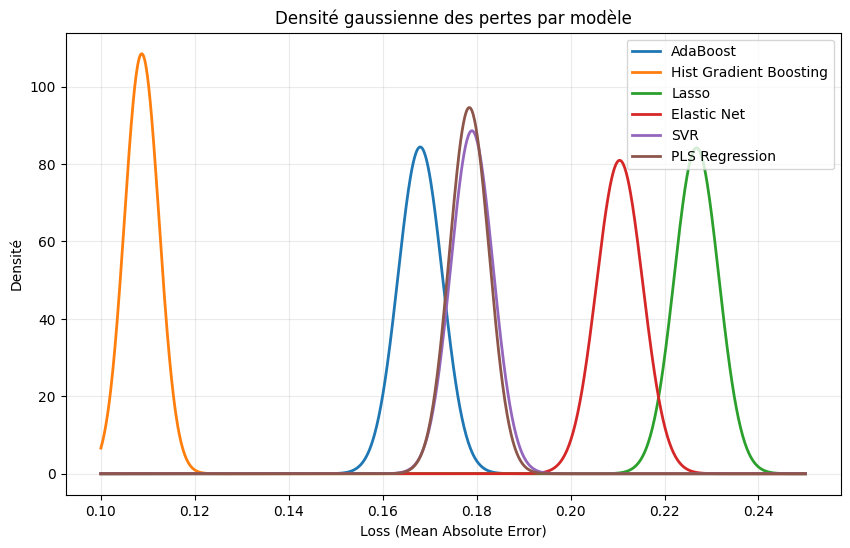

In [44]:
plt.figure(figsize=(10, 6))
x = np.linspace(0.10, 0.25, 1000)

for i in range(len(models_name)):
    mu, std = np.mean(losses[i]), np.std(losses[i])
    plt.plot(x, norm.pdf(x, mu, std), label=models_name[i], linewidth=2)

plt.xlabel("Loss (Mean Absolute Error)")
plt.ylabel("Densité")
plt.title("Densité gaussienne des pertes par modèle")
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()

75 : 'learning_rate': 0.052572472456152035, 'max_iter': 806, 'max_depth': 14, 'min_samples_leaf': 27, 'l2_regularization': 4.729349830351794

108 : 'learning_rate': 0.05144317928360674, 'max_iter': 824, 'max_depth': 15, 'min_samples_leaf': 20, 'l2_regularization': 4.995725971036924

In [29]:
X_train, X_test, y_train, y_test = split_data(optimal_df)
model_4 = init_model_4()
model_4.fit(X_train, y_train)

TypeError: default_mean_field_normal_fn() got an unexpected keyword argument 'trainable'

In [50]:
"""
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "max_iter": trial.suggest_int("max_iter", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 100),
        "l2_regularization": trial.suggest_float("l2_regularization", 0.0, 10.0),
        "loss": "absolute_error" 
    }

    model_x = HistGradientBoostingRegressor(**params, random_state=0)
    model_y = HistGradientBoostingRegressor(**params, random_state=0)
    
    model_x.fit(X_train, y_train[:, 0])
    model_y.fit(X_train, y_train[:, 1])

    y_pred_x = model_x.predict(X_test)
    y_pred_y = model_y.predict(X_test)
    y_pred = np.column_stack((y_pred_x, y_pred_y))

    loss = mean_absolute_error(y_test, y_pred)
    return(loss)
"""
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 2000),
        "max_depth": trial.suggest_int("max_depth", -1, 16),
        "num_leaves": trial.suggest_int("num_leaves", 8, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 300),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
    }

    model_x = LGBMRegressor(**params, verbosity=-1, random_state=0)
    model_y = LGBMRegressor(**params, verbosity=-1, random_state=0)

    model_x.fit(X_train, y_train[:, 0])
    model_y.fit(X_train, y_train[:, 1])

    y_pred_x = model_x.predict(X_test)
    y_pred_y = model_y.predict(X_test)
    y_pred = np.column_stack((y_pred_x, y_pred_y))

    return mean_absolute_error(y_test, y_pred)

results = [] 

for i in range(16):
    X_train, X_test, y_train, y_test = split_data(optimal_df)
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=50, n_jobs=1)

    results.append({"params": study.best_params, "mae": study.best_value})

maes = [r["mae"] for r in results]
mean_mae = float(np.mean(maes))

param_sums = {}
param_counts = {}
for r in results:
    for k, v in r["params"].items():
        if isinstance(v, (int, float)):
            param_sums[k] = param_sums.get(k, 0.0) + float(v)
            param_counts[k] = param_counts.get(k, 0) + 1

mean_params = {k: param_sums[k] / param_counts[k] for k in param_sums}

final_summary = {"mean_mae": mean_mae, "mean_params": mean_params}
print(final_summary)


[I 2026-01-03 13:52:56,249] A new study created in memory with name: no-name-f6c2cfcb-1af9-45bc-b3ec-9eeedb76d80d
[I 2026-01-03 13:52:57,836] Trial 0 finished with value: 0.13333754892422592 and parameters: {'learning_rate': 0.013292918943162165, 'n_estimators': 1904, 'max_depth': 12, 'num_leaves': 157, 'min_child_samples': 47, 'reg_alpha': 1.5599452033620265, 'reg_lambda': 0.5808361216819946}. Best is trial 0 with value: 0.13333754892422592.
[I 2026-01-03 13:52:57,942] Trial 1 finished with value: 0.16158201501695346 and parameters: {'learning_rate': 0.39676050770529875, 'n_estimators': 1222, 'max_depth': 11, 'num_leaves': 13, 'min_child_samples': 291, 'reg_alpha': 8.324426408004218, 'reg_lambda': 2.1233911067827616}. Best is trial 0 with value: 0.13333754892422592.
[I 2026-01-03 13:52:58,128] Trial 2 finished with value: 0.1792564040750902 and parameters: {'learning_rate': 0.0035113563139704067, 'n_estimators': 407, 'max_depth': 4, 'num_leaves': 138, 'min_child_samples': 130, 'reg_al

{'mean_mae': 0.13035719306246873, 'mean_params': {'learning_rate': 0.05329396677395069, 'n_estimators': 1335.75, 'max_depth': 8.75, 'num_leaves': 107.8125, 'min_child_samples': 40.4375, 'reg_alpha': 0.5053147551903368, 'reg_lambda': 3.579416336958513}}


## Affichage d'un point et de sa prédiction

In [13]:
def plot_scatter(y_test, y_pred):
    nb_of_plots = 8
    fig, axes = plt.subplots(2, 4, figsize=(16, 6))
    axes = axes.ravel()
    
    for i in range(nb_of_plots):
        axes[i].scatter(y_test[i, 0], y_test[i, 1], color='green', label='y_test')
        axes[i].scatter(y_pred[i, 0], y_pred[i, 1], color='red', label='y_pred')
        axes[i].set_xlim(0, 1)
        axes[i].set_ylim(0, 1)
        axes[i].set_aspect('equal')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

## Visualisation d'une série de point pour un réseau de neurones et une random forest

Random Forest :


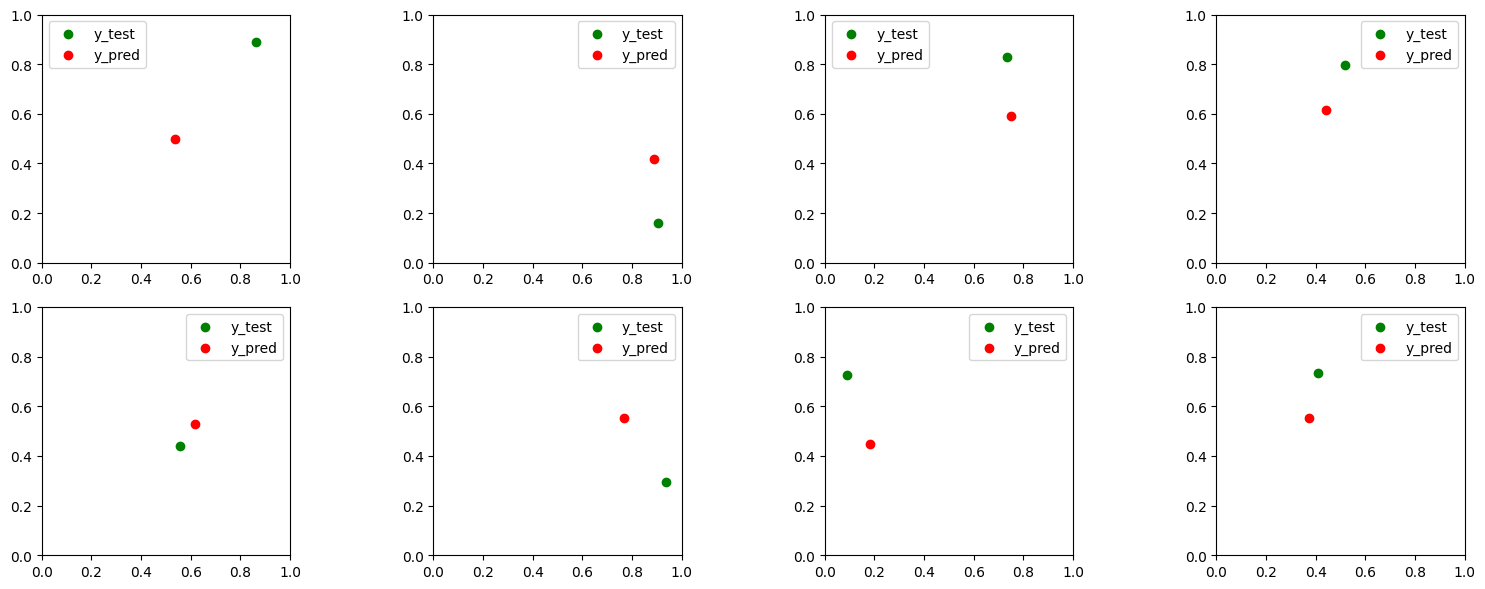

LGBM:


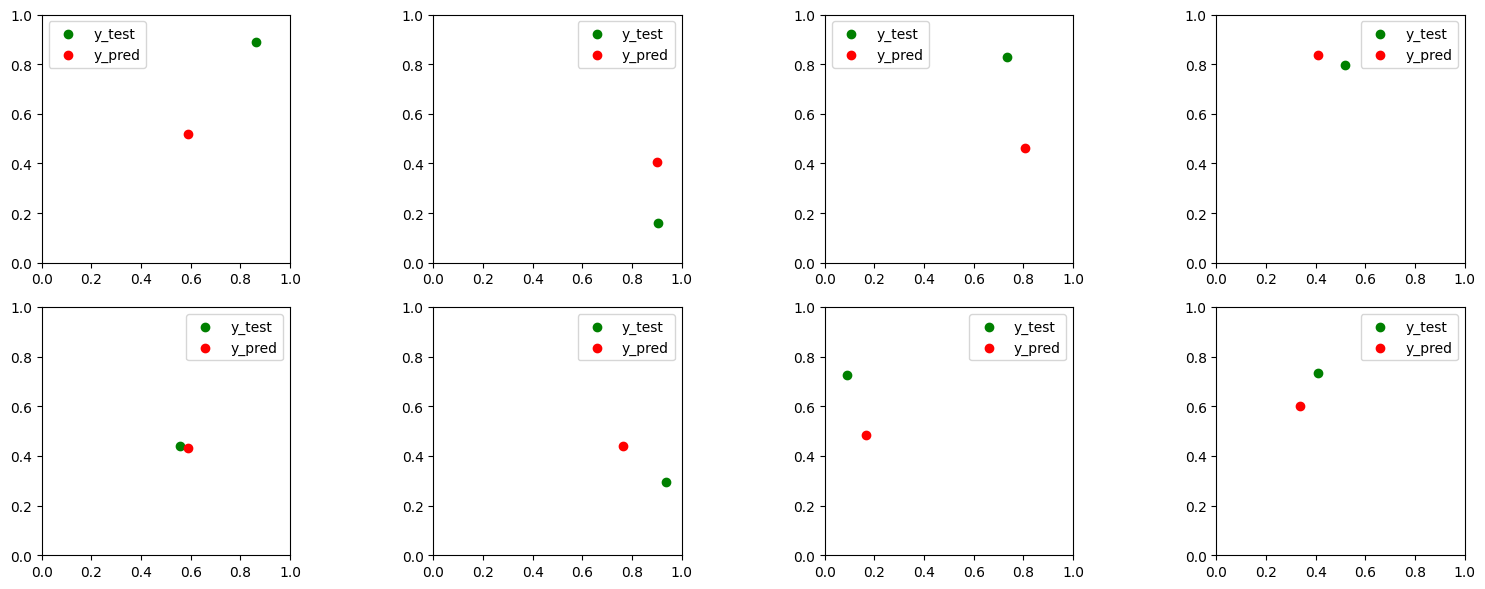

In [23]:
def visalization_RF_LGBM():
    X_train, X_test, y_train, y_test = split_data(optimal_df)
    
    random_forest = RandomForestRegressor()
    
    model_x, model_y = [LGBMRegressor(**params, verbosity=-1), LGBMRegressor(**params, verbosity=-1)]
            
    model_x.fit(X_train, y_train[:, 0])
    model_y.fit(X_train, y_train[:, 1])
    
    y_pred_x = model_x.predict(X_test)
    y_pred_y = model_y.predict(X_test)
    y_pred_lgbm = np.column_stack((y_pred_x, y_pred_y))
    random_forest.fit(X_train, y_train)

    y_pred_RF = random_forest.predict(X_test)

    print("Random Forest :")
    plot_scatter(y_test, y_pred_RF)
    
    print("LGBM:")
    plot_scatter(y_test, y_pred_lgbm)

visalization_RF_LGBM()

## Entraînement d'un réseaux de neurones pour tester l'efficacité du nouveau dataset

Epoch 1/64
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.8289 - mae: 0.8289 - val_loss: 0.9552 - val_mae: 0.9552
Epoch 2/64
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5049 - mae: 0.5049 - val_loss: 0.3028 - val_mae: 0.3028
Epoch 3/64
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3979 - mae: 0.3979 - val_loss: 0.2339 - val_mae: 0.2339
Epoch 4/64
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3365 - mae: 0.3365 - val_loss: 0.2392 - val_mae: 0.2392
Epoch 5/64
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2875 - mae: 0.2875 - val_loss: 0.1904 - val_mae: 0.1904
Epoch 6/64
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2527 - mae: 0.2527 - val_loss: 0.2033 - val_mae: 0.2033
Epoch 7/64
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2360 - mae: 0.2360 - val_loss: 0.1986 - val_mae: 0.1986
Epoch 8/64
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2205 - mae: 0.2205 - val_loss: 0.1831 - val_mae: 0.1831
Epoch 9/64
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

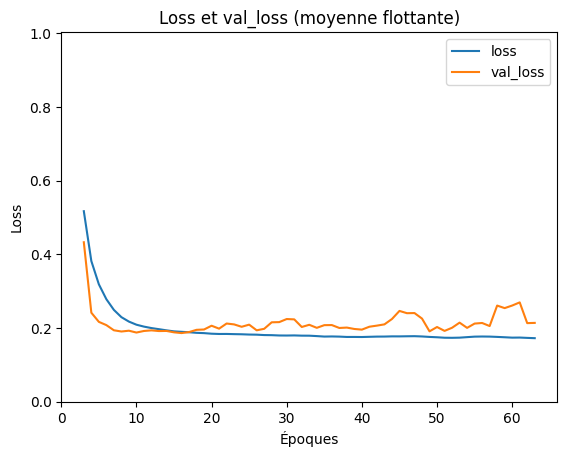

In [18]:
X_train, X_test, y_train, y_test = split_data(optimal_df)
input_length = len(X_train[0])

shaped_model = init_model_1()
epochs = 64
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
shaped_model.compile(loss = "mean_absolute_error", optimizer = optimizer)

history = shaped_model.fit(x = X_train,
                           y = y_train,
                           batch_size = 16,
                           epochs = epochs,
                           validation_data = (X_test, y_test))

def plot_loss(history):
    df_loss = pd.DataFrame(history.history)
    df_loss[["loss", "val_loss"]].rolling(window = 4).mean().plot()
    plt.ylim(0, df_loss[["loss", "val_loss"]].max().max() * 1.05)
    plt.title("Loss et val_loss (moyenne flottante)")
    plt.xlabel("Époques")
    plt.ylabel("Loss")
    plt.show()

plot_loss(history)

## Calibrage du modèle pour l'adapter à l'écran de l'utilisateur

In [17]:
def get_homothety_params(window_size, positions, predictions):

    #######################################
    #                                     #
    # Shape of positions and predictions: #
    #                                     #
    # x_0, y_0                   x_1, y_1 #
    #                                     #
    # x_2, y_2                   x_3, y_3 #
    #                                     #
    #######################################
    
    positions   = np.asarray(positions, dtype=float)
    predictions = np.asarray(predictions, dtype=float)

    if positions.shape != (4, 2) or predictions.shape != (4, 2):
        raise ValueError("positions and predictions have to be arrays of shape (4,2)")

    positions_centroid   = positions.mean(axis=0)
    predictions_centroid = predictions.mean(axis=0)

    translation             = positions_centroid - predictions_centroid
    centered_predictions    = predictions + translation
    centered_positions      = positions - positions_centroid 
    centered_preds_for_size = centered_predictions - positions_centroid 

    pred_row1_width     = centered_preds_for_size[1, 0] - centered_preds_for_size[0, 0]
    pred_row2_width     = centered_preds_for_size[3, 0] - centered_preds_for_size[2, 0]
    pred_mean_row_width = np.mean([pred_row1_width, pred_row2_width])

    pos_row1_width     = centered_positions[1, 0] - centered_positions[0, 0]
    pos_row2_width     = centered_positions[3, 0] - centered_positions[2, 0]
    pos_mean_row_width = np.mean([pos_row1_width, pos_row2_width])

    pred_col1_height     = centered_preds_for_size[2, 1] - centered_preds_for_size[0, 1]
    pred_col2_height     = centered_preds_for_size[3, 1] - centered_preds_for_size[1, 1]
    pred_mean_col_height = np.mean([pred_col1_height, pred_col2_height])

    pos_col1_height     = centered_positions[2, 1] - centered_positions[0, 1]
    pos_col2_height     = centered_positions[3, 1] - centered_positions[1, 1]
    pos_mean_col_height = np.mean([pos_col1_height, pos_col2_height])

    def safe_div(numer, denom):
        denom = float(denom)
        return numer / denom if abs(denom) > 1e-8 else 1.0

    x_scale = safe_div(pos_mean_row_width, pred_mean_row_width)
    y_scale = safe_div(pos_mean_col_height, pred_mean_col_height)

    return(positions_centroid, translation, x_scale, y_scale)


def homothety_correction(prediction, positions_centroid, translation, x_scale, y_scale, window_size):
    prediction = np.asarray(prediction, dtype=float)
    if prediction.shape != (2,):
        raise ValueError("prediction have to be array-like of shape (2,)")

    centered_prediction = prediction + translation
    prediction_vector   = centered_prediction - positions_centroid

    prediction_scaled = np.array([prediction_vector[0] * x_scale,
                                  prediction_vector[1] * y_scale])

    corrected_prediction = positions_centroid + prediction_scaled

    resized_prediction = [corrected_prediction[0] * window_size[0],
                          corrected_prediction[1] * window_size[1]]

    return(resized_prediction)


## Visualisation du facemesh et affichage de la position des lentilles

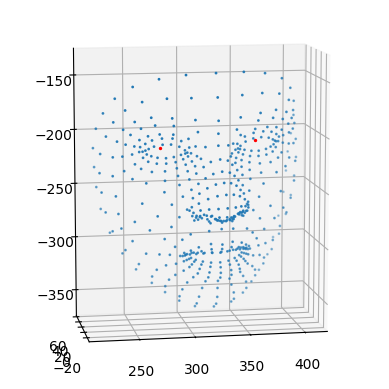

In [155]:
def create_point_cloud(df_row):
    point_cloud = np.zeros((NB_OF_KEYPOINTS, 3))
    for i in range(NB_OF_KEYPOINTS):
        point_cloud[i] = np.array([df_row["x_" + str(i)], df_row["y_" + str(i)], df_row["z_" + str(i)]])

    return(point_cloud)

iloc = 20

df_row = df.iloc[iloc].to_dict()
point_cloud = create_point_cloud(df_row)

centroid = np.mean(point_cloud, axis = 0)
centered = point_cloud - centroid
_, _, transposed_right_singular_vectors = np.linalg.svd(centered)
normal_vector = transposed_right_singular_vectors[-1, :]
unit_normal_vector = normal_vector / np.linalg.norm(normal_vector)

[cx, cy, cz] = centroid
[nx, ny, nz] = unit_normal_vector

u = np.array([1.0, 0.0, 0.0])
if abs(np.dot(u, [nx, ny, nz])) > 0.9:
    u = np.array([0.0, 1.0, 0.0])
    
u -= np.dot(u, [nx, ny, nz]) * np.array([nx, ny, nz])
u /= np.linalg.norm(u)
v = np.cross([nx, ny, nz], u)

s = np.linspace(-100.0, 100.0, 10)
t = np.linspace(-100.0, 100.0, 10)
S, T = np.meshgrid(s, t)
plane = np.array([cx, cy, cz])[:,None,None] + u[:,None,None]*S + v[:,None,None]*T

X, Y, Z = plane[0], plane[1], plane[2]

left_eyes_indexes  = np.array([263, 466, 388, 387, 386, 385, 384, 398, 362, 382, 381, 380, 374, 373, 390, 249])
right_eyes_indexes = np.array([ 33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163,   7])

left_eye  = np.zeros((len(left_eyes_indexes), 3))
right_eye = np.zeros((len(right_eyes_indexes), 3))

for i in range(len(right_eyes_indexes)):
    left_eye[i]  = point_cloud[left_eyes_indexes[i]]
    right_eye[i] = point_cloud[right_eyes_indexes[i]]
    
x_pupil_left  = df.loc[iloc, "x_pupil_left"]
y_pupil_left  = df.loc[iloc, "y_pupil_left"] 
x_pupil_right = df.loc[iloc, "x_pupil_right"] 
y_pupil_right = df.loc[iloc, "y_pupil_right"] 

left_look_vector  = get_look_vector(x_pupil_left, y_pupil_left, left_eye)
right_look_vector = get_look_vector(x_pupil_right, y_pupil_right, right_eye)

left_centroid = np.mean(left_eye, axis = 0)
right_centroid = np.mean(right_eye, axis = 0)

[lcx, lcy, lcz] = left_centroid
[lnx, lny, lnz] = left_look_vector

[rcx, rcy, rcz] = right_centroid
[rnx, rny, rnz] = right_look_vector

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X, Z, -Y, alpha=0.3, color='C0')
ax.scatter(point_cloud[:, 0], point_cloud[:, 2], -point_cloud[:, 1], s=1)
ax.scatter([lcx+lnx],[lcz+lnz],[-lcy-lny], color='r', s=2)
ax.scatter([rcx+rnx],[rcz+rnz],[-rcy-rny], color='r', s=2)
#ax.quiver(cx, cz, -cy, nx, nz, -ny, length=80, color='k')
#ax.quiver(lcx, lcz, -lcy, lnx, lnz, -lny, length=12, color='r')
#ax.quiver(rcx, rcz, -rcy, rnx, rnz, -rny, length=12, color='r')

ax.set_aspect('equal')
ax.view_init(elev=10, azim=-100) 
plt.show()

## Tentative infructueuse pour améliorer le modèle : prendre en compte le globe oculaire et projeter le regard dans le plan de l'écran

In [91]:
def sphere_from_points(points):
    A, B, C, D = points

    AB = B - A
    AC = C - A
    AD = D - A
    
    n1 = np.cross(AB, AC)
    n2 = np.cross(AB, AD)
    n3 = np.cross(AC, AD)

    center = np.linalg.solve(np.array([n1, n2, n3]),
                             np.array([0.5 * (np.dot(B, B) - np.dot(A, A)),
                                       0.5 * (np.dot(C, C) - np.dot(A, A)),
                                       0.5 * (np.dot(D, D) - np.dot(A, A))]))

    radius = np.linalg.norm(center - A)

    return(center, radius)

def get_sphere_center(eye, radius):
    A, B = eye
    centroid = np.mean(eye, axis = 0)
    center = centroid
    
    dx = center[0] - A[0]
    dy = center[1] - A[1]
    current_distance_xy = np.sqrt(dx**2 + dy**2)
    
    if current_distance_xy >= radius:
        raise ValueError("No solutions : xy distance is to big.")
    
    dz = np.sqrt(radius**2 - current_distance_xy**2)
    new_z = A[2] + dz
    
    center = np.array([center[0], center[1], new_z])
    return(center)

def get_xy_coords(center, radius, x_pupil, y_pupil):
    dz = np.sqrt(max(0, radius**2 - (x_pupil - center[0])**2 - (y_pupil - center[1])**2))
    z_pupil = center[2] - dz

    pupil = np.array([x_pupil, y_pupil, z_pupil])
    look_vector = pupil - center

    screen_distance = 400
    scaler = (screen_distance - center[2]) / look_vector[2]

    x_coord = center[0] + scaler * look_vector[0]
    y_coord = center[1] + scaler * look_vector[1]

    xy_coords = np.array([x_coord, y_coord])
    return(xy_coords)

iloc = 0

df_row = df.iloc[iloc].to_dict()
point_cloud = create_point_cloud(df_row)

x_pupil_left  = df.loc[iloc, "x_pupil_left"]
y_pupil_left  = df.loc[iloc, "y_pupil_left"] 
x_pupil_right = df.loc[iloc, "x_pupil_right"] 
y_pupil_right = df.loc[iloc, "y_pupil_right"] 

#left_eyes_indexes  = np.array([263, 386, 362, 374])
#right_eyes_indexes = np.array([ 33, 159, 133, 145])

left_eyes_indexes  = np.array([386, 374])
right_eyes_indexes = np.array([159, 145])

left_eye  = np.zeros((len(left_eyes_indexes), 3))
right_eye = np.zeros((len(right_eyes_indexes), 3))

for i in range(len(right_eyes_indexes)):
    left_eye[i]  = point_cloud[left_eyes_indexes[i]]
    right_eye[i] = point_cloud[right_eyes_indexes[i]]

radius = 12.5 # radius of a human eye

left_center  = get_sphere_center(left_eye, radius)
right_center = get_sphere_center(right_eye, radius)

left_look_vector = get_look_vector(left_center, radius, x_pupil_left, y_pupil_left)
right_look_vector = get_look_vector(right_center, radius, x_pupil_right, y_pupil_right)

lcx, lcy, lcz = left_center
rcx, rcy, rcz = right_center
lnx, lny, lnz = left_look_vector
rnx, rny, rnz = right_look_vector


#left_center,  left_radius  = sphere_from_points(left_eye)
#right_center, right_radius = sphere_from_points(right_eye)


lu, lv = np.mgrid[0:2 * np.pi:20j, 0:np.pi:10j]
lx = left_center[0] + radius * np.cos(lu) * np.sin(lv)
ly = left_center[1] + radius * np.sin(lu) * np.sin(lv)
lz = left_center[2] + radius * np.cos(lv)

ru, rv = np.mgrid[0:2 * np.pi:20j, 0:np.pi:10j]
rx = right_center[0] + radius * np.cos(ru) * np.sin(rv)
ry = right_center[1] + radius * np.sin(ru) * np.sin(rv)
rz = right_center[2] + radius * np.cos(rv)

TypeError: get_look_vector() takes 3 positional arguments but 4 were given

NameError: name 'lcx' is not defined

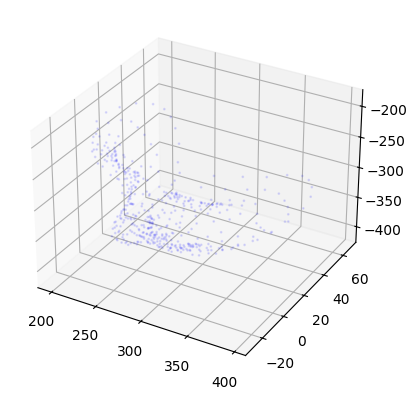

In [92]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(left_eye[:, 0], left_eye[:, 2], -left_eye[:, 1], color='r', s=4)
#ax.scatter(right_eye[:, 0], right_eye[:, 2], -right_eye[:, 1], color='g', s=4)
ax.scatter(point_cloud[:, 0], point_cloud[:, 2], -point_cloud[:, 1], color='b', alpha=0.1, s=1)
ax.quiver(lcx, lcz, -lcy, lnx, lnz, -lny, length=10, color='r')
ax.quiver(rcx, rcz, -rcy, rnx, rnz, -rny, length=10, color='r')
ax.plot_wireframe(lx, lz, -ly, color="k", alpha=0.05)
ax.plot_wireframe(rx, rz, -ry, color="k", alpha=0.05)

ax.set_aspect('equal')
ax.view_init(elev=10, azim=-70) 
plt.show()

## Analyse des features dans la prises de décision du modèle afin de déterminer les informations inutiles dans le dataset

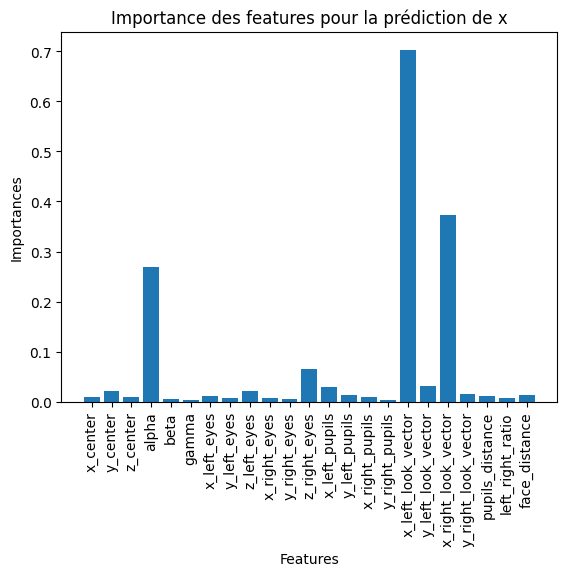

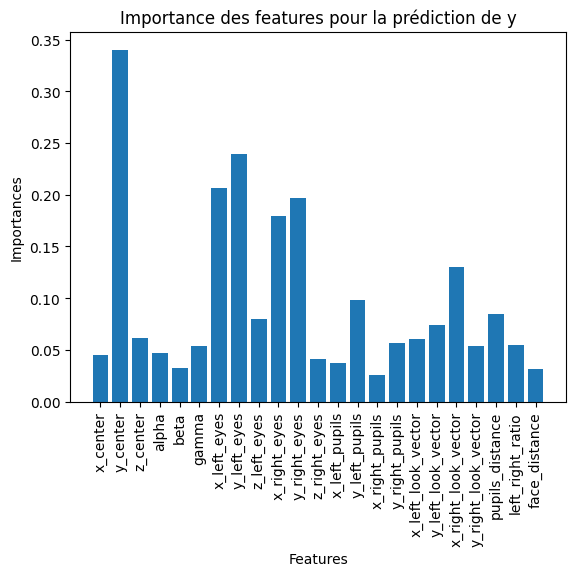

In [30]:
model_x = HistGradientBoostingRegressor()
model_y = HistGradientBoostingRegressor()

clf_x = model_x.fit(X_train, y_train[:, 0])
clf_y = model_y.fit(X_train, y_train[:, 1])

y_pred_x = model_x.predict(X_test)
y_pred_y = model_y.predict(X_test)

loss_x = mean_absolute_error(y_test[:, 0], y_pred_x)
loss_y = mean_absolute_error(y_test[:, 1], y_pred_y)

result_x = permutation_importance(clf_x, X_train, y_train[:, 0], n_repeats=64, random_state=0)
result_y = permutation_importance(clf_y, X_train, y_train[:, 1], n_repeats=64, random_state=0)

labels = ["x_center", 
          "y_center", 
          "z_center", 
          "alpha",
          "beta",
          "gamma", 
          "x_left_eyes",
          "y_left_eyes",
          "z_left_eyes",
          "x_right_eyes",
          "y_right_eyes",
          "z_right_eyes",
          "x_left_pupils",
          "y_left_pupils",
          "x_right_pupils",
          "y_right_pupils",
          "x_left_look_vector",
          "y_left_look_vector",
          "x_right_look_vector",
          "y_right_look_vector",
          "pupils_distance",
          "left_right_ratio",
          "face_distance"]

meaned_result_x = result_x.importances_mean
meaned_result_y = result_y.importances_mean

plt.figure(0)
plt.bar(labels, meaned_result_x)
plt.xlabel('Features')
plt.ylabel('Importances')
plt.title('Importance des features pour la prédiction de x')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(1)
plt.bar(labels, meaned_result_y)
plt.xlabel('Features')
plt.ylabel('Importances')
plt.title('Importance des features pour la prédiction de y')
plt.xticks(rotation='vertical')
plt.show()

In [30]:
n = 16
losses_x = np.zeros(n)
losses_y = np.zeros(n)
losses   = np.zeros(n)
for i in range(n):
    X_train, X_test, y_train, y_test = split_data(optimal_df)

    #elements_to_delete_x = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 20, 21, 22]
    elements_to_delete_x = []
    X_train_x = np.delete(X_train, elements_to_delete_x, axis=1)
    X_test_x = np.delete(X_test, elements_to_delete_x, axis=1)

    #elements_to_delete_y = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22]
    elements_to_delete_y = []
    X_train_y = np.delete(X_train, elements_to_delete_y, axis=1)
    X_test_y = np.delete(X_test, elements_to_delete_y, axis=1)
    
    model_x = HistGradientBoostingRegressor()
    model_y = HistGradientBoostingRegressor()
    
    clf_x = model_x.fit(X_train_x, y_train[:, 0])
    clf_y = model_y.fit(X_train_y, y_train[:, 1])
    
    y_pred_x = model_x.predict(X_test_x)
    y_pred_y = model_y.predict(X_test_y)
    
    y_pred = np.column_stack((y_pred_x, y_pred_y))

    losses[i] = mean_absolute_error(y_test, y_pred)
    losses_x[i] = mean_absolute_error(y_test[:, 0], y_pred_x)
    losses_y[i] = mean_absolute_error(y_test[:, 1], y_pred_y)

#print(np.mean(losses_x))
#print(np.mean(losses_y))
#print(np.mean([losses_x, losses_y]))
print(np.mean(losses))

0.13357995612330836


In [39]:
prediction = np.array([[0, 0], [1, 1]])
target = np.array([[0, 0.1], [1, 0.9]])
print(mean_absolute_error(prediction, target))
print(np.mean([mean_absolute_error(prediction[:, 0], target[:, 0]), mean_absolute_error(prediction[:, 1], target[:, 1])]))

0.049999999999999996
0.049999999999999996


In [37]:
print(np.mean([np.mean(losses_x), np.mean(losses_y)]))

0.10733160575447273


## Affichage des performances du modèle en fonction de la taille du dataset

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


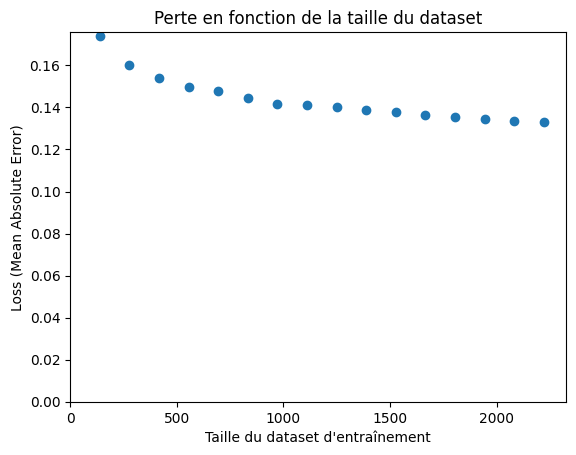

In [14]:
n = 16
m = 16
losses = np.zeros((m, n))
n_samples = np.zeros((m, n))
for i in range(m):
    X_train, X_test, y_train, y_test = split_data(optimal_df)
    for j in range(n):
        n_sample = int(len(X_train) * (j + 1) / n)
        n_samples[i][j] = n_sample
        
        model_x = HistGradientBoostingRegressor()
        model_y = HistGradientBoostingRegressor()
        
        clf_x = model_x.fit(X_train[:n_sample], y_train[:n_sample][:, 0])
        clf_y = model_y.fit(X_train[:n_sample], y_train[:n_sample][:, 1])
        
        y_pred_x = model_x.predict(X_test)
        y_pred_y = model_y.predict(X_test)
        
        y_pred = np.column_stack((y_pred_x, y_pred_y))
    
        losses[i][j] = mean_absolute_error(y_test, y_pred)
        #losses_x[j] = mean_absolute_error(y_test[:, 0], y_pred_x)
        #losses_y[j] = mean_absolute_error(y_test[:, 1], y_pred_y)
    print(i)

#coefficients = np.polyfit(n_samples, losses, 2)
#polynome = np.poly1d(coefficients)

regression = PoissonRegressor()

regression.fit(n_samples.reshape(-1, 1), losses.reshape(-1, 1))

x_fit = np.linspace(min(np.mean(n_samples, axis=0)), max(np.mean(n_samples, axis=0)), 400)
prediction = regression.predict(x_fit.reshape(-1, 1))

plt.scatter(np.mean(n_samples, axis=0), np.mean(losses, axis=0))
#plt.plot(x_fit, prediction, color='red')
plt.xlabel("Taille du dataset d'entraînement")
plt.ylabel("Loss (Mean Absolute Error)")
plt.title("Perte en fonction de la taille du dataset")
plt.xlim(left=0)  
plt.ylim(bottom=0)
plt.show()


In [25]:
params = {'learning_rate': 0.05329396677395069, 'n_estimators': 1334, 'max_depth': 9, 'num_leaves': 108, 'min_child_samples': 40, 'reg_alpha': 0.5053147551903368, 'reg_lambda': 3.579416336958513}
model_x, model_y = LGBMRegressor(**params, verbosity=-1), LGBMRegressor(**params, verbosity=-1)

print(np.shape(X_train))

#X = np.array([X_train, X_test])

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)


print(len(X_train))
print(len(X_test))
print(len(X))


model_x.fit(X, y[:, 0])
model_y.fit(X, y[:, 1])

y_pred_x = model_x.predict(X_test)
y_pred_y = model_y.predict(X_test)
y_pred = np.column_stack((y_pred_x, y_pred_y))

print(mean_absolute_error(y_test, y_pred))


with open('lightgbm_model_x.pkl', 'wb') as f:
    pickle.dump(model_x, f)

with open('lightgbm_model_y.pkl', 'wb') as f:
    pickle.dump(model_y, f)

model_x.booster_.save_model('lightgbm_model_x.pkl') 
model_y.booster_.save_model('lightgbm_model_y.pkl') 


(2221, 23)
2221
247
2468
0.03163344452817563
